In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport
import src.dataHandling.cleaningUtils as clean
import os
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


In [2]:
def drop_irrelevant(df: pd.DataFrame) -> pd.DataFrame:
    """
    drops columns which are irrelevant for the model (mostly ids)
    :param df: pd.DataFrame
    :return: None
    """
    irrelevant_cols = []
    general_irrelevant = ['gameDuration', 'gameCreation', 'gameVersion', 'mapId', 'queueId', 'patch', 'seasonId',
                          'platformId']
    irrelevant_cols.extend(general_irrelevant)
    participant_irrelevant = ['win']
    for i in range(1, 11):
        for col in participant_irrelevant:
            irrelevant_cols.append(f'participant{i}_{col}')
    df_new = df.drop(columns=irrelevant_cols)
    return df_new

In [3]:
try:
    with open("data/raw/static_dataset.pkl", "rb") as f:
        df = pickle.load(f)
except FileNotFoundError:
    os.chdir('../')
    with open("data/raw/static_dataset.pkl", "rb") as f:
        df = pickle.load(f)
df = clean.drop_missing(df)
print(f'Found {len(df)} rows after dropping missing values')
df = clean.drop_wrong_data(df)
df.reset_index(drop=True, inplace=True)
df = clean.fix_rank(df)
df = clean.calc_winrate(df)
df = clean.fix_teamId(df)
df = clean.convert_booleans(df)
df = clean.convert_lastPlayTime(df)
df = clean.convert_championTier(df)
df = clean.get_winning_team(df)  # this has to be the last step where a column is inserted
df = clean.drop_wrong_teamIds(df)
df = drop_irrelevant(df)
assert df.columns[-1] == 'label'
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                    df.iloc[:, -1],
                                                    test_size=0.1,
                                                    random_state=42,
                                                    shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.1,
                                                  random_state=42,
                                                  shuffle=True)

dropped 17648 rows
Found 20513 rows after dropping missing values
found 20513 rows
dropped wrong mapId
dropped wrong queueId
dropped wrong gameDuration
dropped wrong seasonId
dropped wrong gameVersion
dropped wrong patch
dropped 0 wrong rows
dropped 563 rows


In [4]:
df.head()

participant1_level  participant1_tier  participant1_leaguePoints  \
0                 864                7.1                        177   
1                 196                7.1                        513   
2                 465                6.2                         75   
4                 110                7.1                        298   
5                 466                7.1                        555   

   participant1_veteran  participant1_inactive  participant1_freshBlood  \
0                     1                      0                        0   
1                     0                      0                        1   
2                     0                      0                        0   
4                     0                      0                        0   
5                     0                      0                        0   

   participant1_hotStreak  participant1_champion_lastPlayTime  \
0                       0                             2906854   
1                       0                             2986081   
2                       0                             2766908   
4                       1                             2574460   
5                       1                             2845111   

   participant1_champion_championLevel  participant1_champion_championPoints  \
0                                    3                                  9801   
1                                    5                               1051316   
2                                    7                                 57996   
4                                    7                                 61840   
5                                    7                                 34728   

   ...  participant2_winrate  participant3_winrate  participant4_winrate  \
0  ...              0.530488              0.532895              0.510417   
1  ...              0.556911              0.567442              0.522831   
2  ...              0.483871              0.496241              0.571429   
4  ...              0.527304              0.833333              0.536810   
5  ...              0.531250              0.543662              0.536170   

   participant5_winrate  participant6_winrate  participant7_winrate  \
0              0.517986              0.525597              0.491667   
1              0.564220              0.538217              0.536458   
2              0.500000              0.496479              0.440000   
4              0.523529              0.513869              0.512535   
5              0.622951              0.550000              0.552743   

   participant8_winrate  participant9_winrate  participant10_winrate  label  
0              0.549020              0.497268               0.470588      0  
1              0.541063              0.542683               0.548736      0  
2              0.628571              0.493506               0.564935      1  
4              0.565891              0.544304               0.510453      0  
5              0.594406              0.529787               0.572864      0  

[5 rows x 331 columns]

In [5]:
bst = xgb.XGBClassifier(n_estimators=200, max_depth=30, learning_rate=0.1, objective='binary:logistic', device='cpu')

In [6]:
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
bst.score(X_test, y_test)

0.7182957393483709

In [8]:
X_train.columns.values

array(['participant1_level', 'participant1_tier',
       'participant1_leaguePoints', 'participant1_veteran',
       'participant1_inactive', 'participant1_freshBlood',
       'participant1_hotStreak', 'participant1_champion_lastPlayTime',
       'participant1_champion_championLevel',
       'participant1_champion_championPoints',
       'participant1_champion_championPointsSinceLastLevel',
       'participant1_champion_tokensEarned', 'participant1_champion_kda',
       'participant1_champion_kills', 'participant1_champion_deaths',
       'participant1_champion_assists', 'participant1_champion_lp',
       'participant1_champion_maxKills', 'participant1_champion_cs',
       'participant1_champion_damage', 'participant1_champion_gold',
       'participant1_champion_championNumber',
       'participant1_champion_infoAttack',
       'participant1_champion_infoDefense',
       'participant1_champion_infoMagic',
       'participant1_champion_infoDifficulty',
       'participant1_champion_tie

FixedFormatter should only be used together with FixedLocator


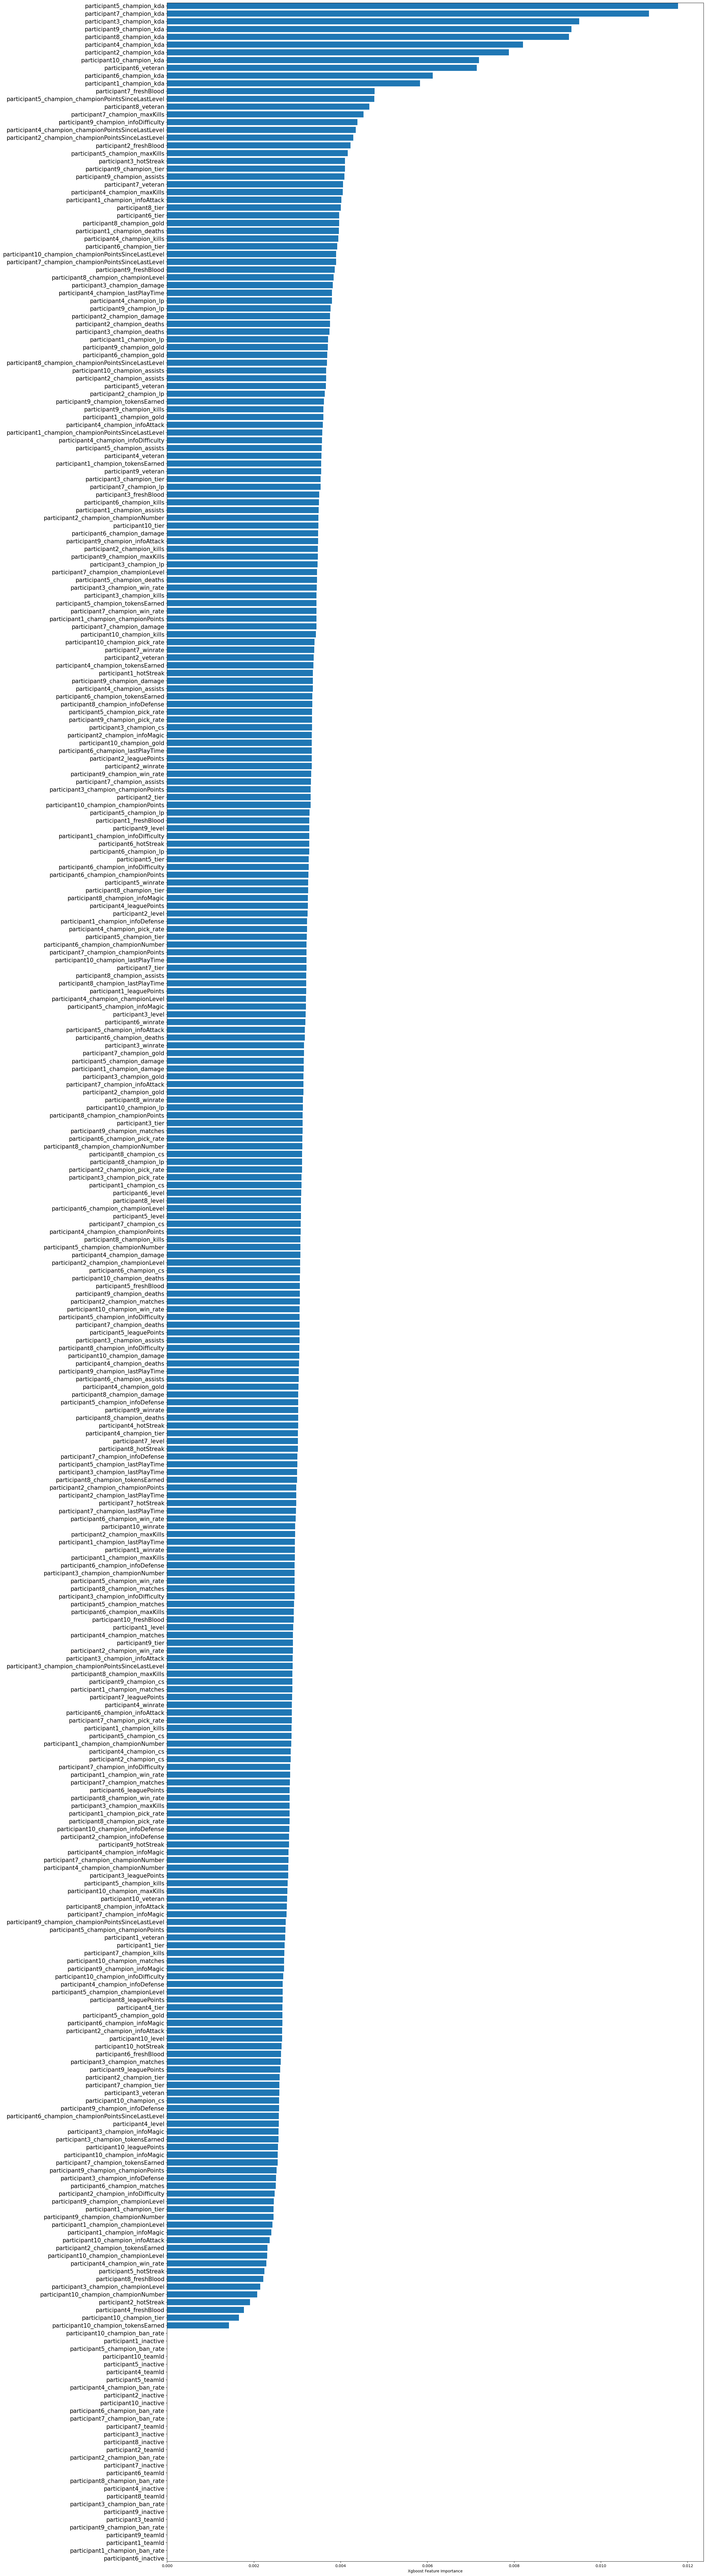

In [9]:
sorted_idx = bst.feature_importances_.argsort()
fig, ax = plt.subplots(figsize=(25, 120))
ax.set_yticklabels(X_train.columns.values[sorted_idx], fontsize=15)
ax.margins(y=0)
plt.barh(X_train.columns.values[sorted_idx], bst.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [23]:
X_train.columns.values[sorted_idx].tolist()[0:20]

['participant4_level',
 'participant9_champion_infoMagic',
 'participant8_champion_pick_rate',
 'participant10_champion_infoDefense',
 'participant7_level',
 'participant2_champion_kills',
 'participant1_champion_win_rate',
 'participant6_champion_damage',
 'participant6_champion_championNumber',
 'participant4_winrate',
 'participant2_champion_infoDifficulty',
 'participant1_champion_gold',
 'participant10_champion_kills',
 'participant2_champion_lastPlayTime',
 'participant10_champion_championPoints',
 'participant2_champion_championPointsSinceLastLevel',
 'participant5_champion_championPoints',
 'participant1_champion_lp',
 'participant3_champion_cs',
 'participant4_champion_infoDefense']

In [33]:
bst2 = xgb.XGBClassifier(n_estimators=500, max_depth=80, learning_rate=0.1, objective='binary:logistic', device='cpu')
bst2.fit(X_train[X_train.columns.values[sorted_idx].tolist()], y_train)
bst2.score(X_test[X_train.columns.values[sorted_idx].tolist()], y_test)

0.7213032581453634

In [11]:
num_round = 100
param = {
    "eta": 0.05,
    "max_depth": 10,
    "tree_method": "hist",
    "device": "cuda",
}

In [12]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.values.tolist())
model = xgb.train(param, dtrain, num_round)

In [13]:
model.set_param({"device": "cuda"})
shap_values = model.predict(dtrain, pred_contribs=True)

In [14]:
shap_interaction_values = model.predict(dtrain, pred_interactions=True)

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

[15:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


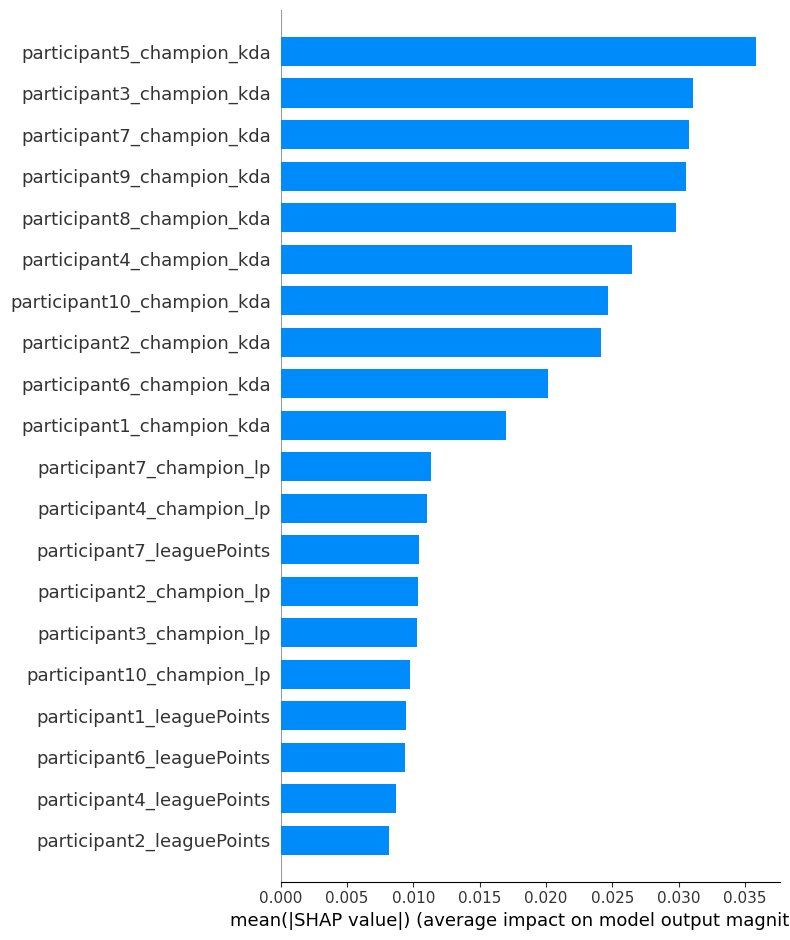

In [16]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

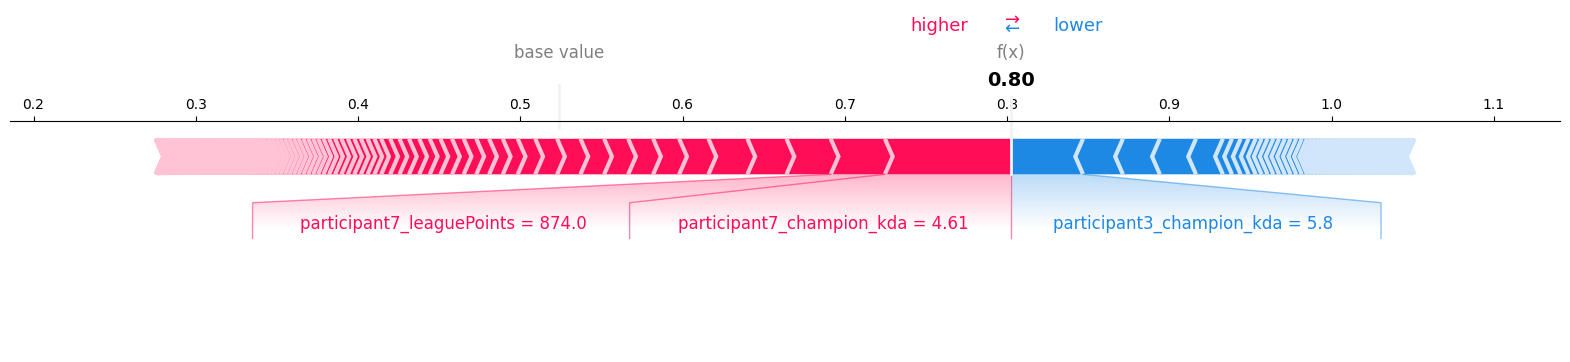

In [17]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_train.to_numpy()[0, :],
    feature_names=X_train.columns.values.tolist(),
    matplotlib=True,
)

FixedFormatter should only be used together with FixedLocator


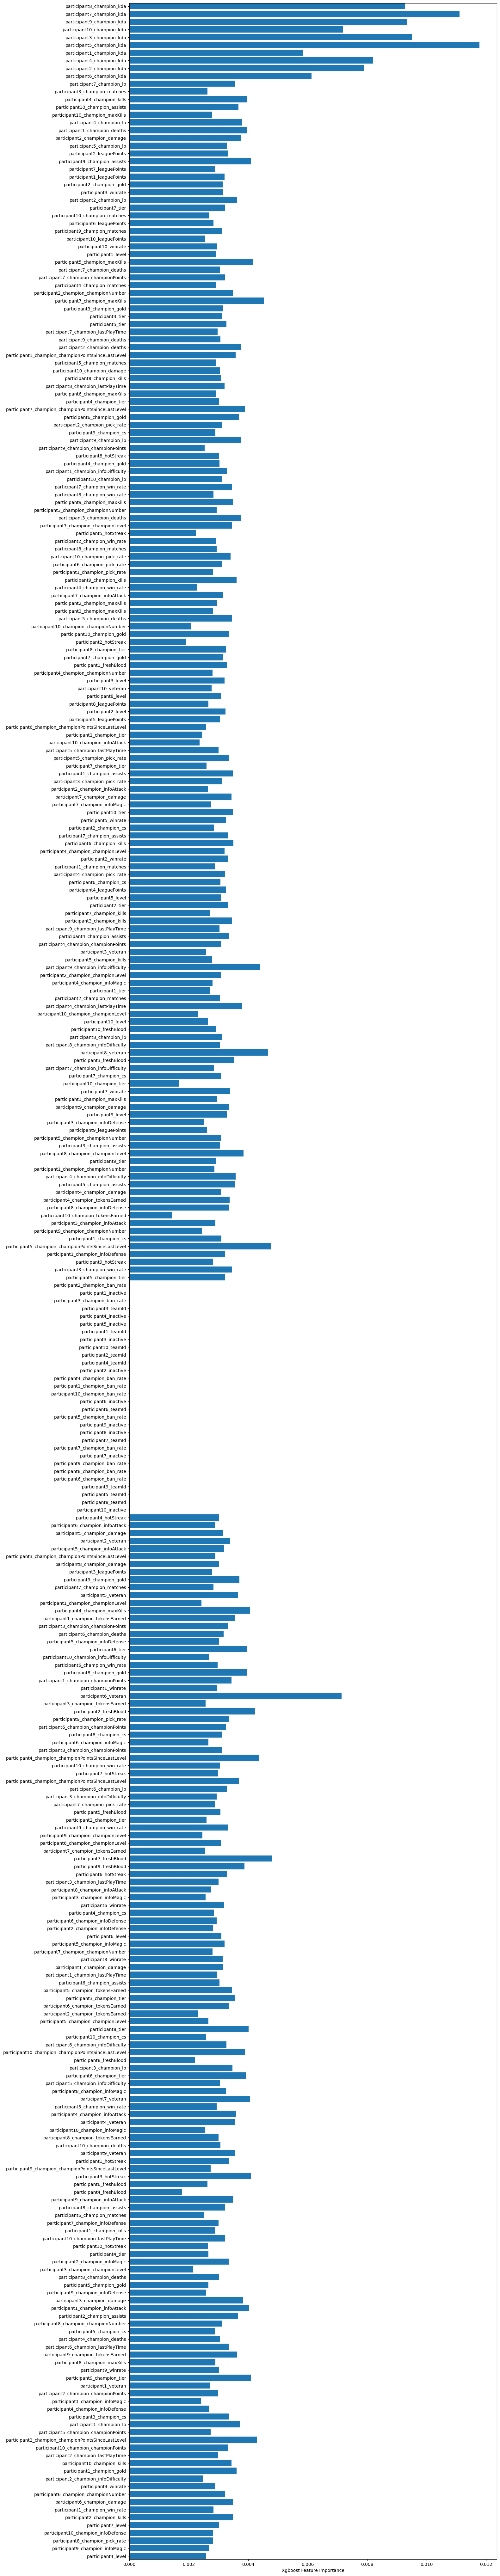

In [18]:
perm_importance = permutation_importance(bst, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(15, 105))
ax.set_yticklabels(X_train.columns.values[sorted_idx], fontsize=10)
ax.margins(y=0)
plt.barh(X_train.columns.values[sorted_idx], bst.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [19]:
X_train[X_train.columns.values[sorted_idx][-1]]

3109     2.11
18747    2.94
7141     4.13
7338     4.29
19651    4.23
         ... 
18140    1.99
19559    2.69
9734     1.84
1345     1.27
5413     2.29
Name: participant8_champion_kda, Length: 16159, dtype: float64